In [1]:
import csv
import os
import glob
import pandas as pd
import string
import re
import multiprocessing
import time
import editdistance
import itertools
from collections import Counter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
#pd.set_option('display.width', 1000)
from tqdm import tqdm

In [2]:
os.chdir("D://Scriptie//Data//lines//cleaned")
all_txt = glob.glob('*.txt')
all_txt = [f for f in all_txt if f[6:12] == 'leaned']

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D://Scriptie//Data//lines//cleaned'

In [9]:
stopz = [word.split() for word in open("C:\\Users\\Ruben\\Documents\\Artikelen\\Joris\\stopwords-nl.txt", 'r', encoding = "utf-8").readlines()]
stopz = [item for sublist in stopz for item in sublist]

In [10]:
def Get_KWIC(search_term, start_year, end_year, window_left, window_right, dist):
    kwics_year = dict()
    
    for year in range(start_year, end_year+1):
    
        list_lines_year = list()

        files = [s for s in all_txt if str(year) in s]

        for file in files:
            lines = [line.rstrip('\n') for line in open(file, encoding = 'utf-8')]
            lines = [line for line in lines if search_term in line]
            
            #print(str(year) + ' occurences: ' + str(len(lines)))
            
            for line in lines:


                tmp_line = line.replace(search_term, '_'.join(search_term.split(' ')))


                line_tok = tmp_line.split(" ")
                positions = [idx for idx, s in enumerate(line_tok) if '_'.join(search_term.split(' ')) in s]

                for pos in positions:
                    p = int(pos)
                    ss = p - dist - window_left
                    se = p - dist
                    es = p + dist
                    ee = p + dist + window_right

                    if ss < 0:
                        se = 0
                    if ee > (len(line_tok) - 1):
                        ee = (len(line_tok) - 1)

                    selection = " ".join(line_tok[ss:se] + line_tok[es:ee])
                    list_lines_year.append(selection)
                    
            kwics_year.update({year:list_lines_year})
    
    kwic_df = pd.DataFrame()
    for key,value in kwics_year.items():
        for line in value:
            tmp = pd.DataFrame([line], columns = ['kwic'])
            tmp['year'] = key
            kwic_df = kwic_df.append(tmp)
    kwic_df = kwic_df.reset_index(drop=True)
    
    return kwic_df

In [11]:
def Get_KWICTW(search_term, start_year, end_year, window_left, window_right, dist):
    
    dft = Get_KWIC(search_term, start_year, end_year, window_left, window_right, dist)
    
    
    df_top = pd.DataFrame()
    for year in sorted(list(set(dft['year']))):
        ss = dft[dft['year'] == year]
        list_words = list(itertools.chain.from_iterable(ss.kwic.str.split(' ')))
        list_words = [w for w in list_words if w not in stopz]
        list_words = [w for w in list_words if w != '_'.join(search_term.split(' '))]
        list_words = Counter(list_words)
        
        for word, count in dict(list_words.most_common(500)).items():
            if count > 1:
                tmpdf = pd.DataFrame([word,count]).T
                tmpdf['year'] = year
                df_top = df_top.append(tmpdf)
        

    
    df_top.columns = ['word', 'count', 'year']
    df_top = df_top.pivot(index='word',columns='year')     
    return df_top

In [6]:
df = Get_KWICTW('buitenlandsche', 1815, 1914, 24, 24, 0)
os.chdir("C:\\Users\\Ruben\\Documents\\Scriptie\\Data\\kwic_dfs\\top_bigrams_top_words")
fn = "buitenlandsche_1815_1914_tw_c24.csv"
df.columns = df.columns.get_level_values(1)
df.to_csv(fn, index = True)
os.chdir("D://Scriptie//Data//lines//cleaned")

In [11]:
df = Get_KWICTW('buitenlanders', 1815, 1914, 12, 12, 0)
os.chdir("C:\\Users\\Ruben\\Documents\\Scriptie\\Data\\kwic_dfs\\top_bigrams_top_words")
fn = "buitenlanders_1815_1914_tw_c12.csv"
df.columns = df.columns.get_level_values(1)
df.to_csv(fn, index = True)
os.chdir("D://Scriptie//Data//lines//cleaned")

In [155]:
change_df = pd.DataFrame()

for i in range(1,(len(df.columns))):
    tmp = df.sort_values(df.columns[i], ascending = False)
    tmp = list(tmp.index[0:13])
    
    tmpp = df.sort_values(df.columns[i - 1], ascending = False)
    tmpp = list(tmpp.index[0:13])
    
    tmp = pd.DataFrame([len([word for word in tmp if word not in tmpp])])
    tmp['year'] = df.columns[i]
    change_df = change_df.append(tmp)
change_df.columns = ['c', 'y']

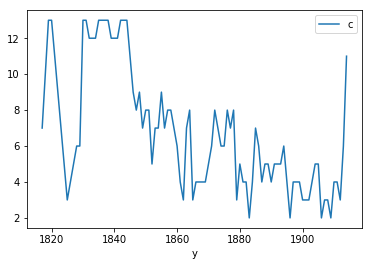

In [156]:
p = change_df.plot.line(x='y', y='c')
p

In [157]:
os.chdir("C:\\Users\\Ruben\\Documents\\Scriptie\\Data\\kwic_dfs")

df.to_csv('in_het_buitenland_1815_1914_tw_c48d0.csv', index = True)

In [125]:
df.sort_values(['1906'], ascending = False)

year,1815,1818,1821,1822,1823,1824,1826,1827,1828,1830,...,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914
word,,,,,,,,,,,,,,,,,,,,,
buitenlandsche_vijanden,NaN,2,5,7,5,3,5,2,NaN,6,...,6,3,19,10,5,4,4,9,18,10
arbeiders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bestaan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blijft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eigenwaarde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gehouden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
staat,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,7,NaN,NaN,NaN,NaN,2,NaN,NaN
volk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
